# Exploratory Analysis of Bay Area Bike Share Data

The initial load and cleanup step produces a new, combined dataset which is then saved. After the first run, we can skip this step and head directly to the [initial assessment](#Reload-and-Initial-Assessment). Before going anywhere, however, run the cell below to import the necessary libraries and set up some global variables.

In [1]:
# shared imports and global variables
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sb

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

bc = sb.color_palette()[0]

import gmaps
import gmaps.datasets 

gkey = %env GOOGLE_API_KEY
gmaps.configure(api_key=gkey)

## Contents
1. [Initial Load and Cleanup](#Initial-Load-and-Cleanup)
2. [Reload and Initial Assessment](#Reload-and-Initial-Assessment)
3. [Enhancing the Data](#Enhancing-the-Data)
4. [Time Series Analysis](#Time-Series-Analysis)
5. [Faceting](#Faceting)
6. [Geographic Data](#Geographic-Data)
7. [Conclusions](#Conclusions)

## Initial Load and Cleanup
[back to contents](#Contents)

We'll begin by loading up our datasets, which are available here: https://www.lyft.com/bikes/bay-wheels/system-data

We already notice something interesting. When the data began being collected, it was saved and labelled as `fordgobike-tripdata.csv`, preceded by what looks like year and month; ie, `201806-fordgobike-tripdata.csv.zip`. Then, beginning with the May 2019 dataset, the filename format switches to `baywheels-tripdata`. We see also that the site now carries Lyft branding. Poking around a little, we learn that Ford and Lyft have partnered on a few projects, and at some point Lyft took over Ford's bikeshare program: https://blog.lyft.com/posts/introducing-bay-wheels-new-bikes-and-a-new-name

For our purposes, this is worth noting because it might affect the format of the datasets and require some wrangling. We'll begin by loading the datasets into memory and seeing what's there. Immediately, we run into an issue: one file uses a different delimiter from all the others.

In [2]:
csvs = [ f for f in os.listdir('data') if f.endswith('.csv')]
data = {}
for c in csvs:
    try:
        if c == '201907-baywheels-tripdata.csv':
            data[ c[:c.index('-')] ] = pd.read_csv(os.path.join('data', c), sep=";")
        else:
            data[ c[:c.index('-')] ] = pd.read_csv(os.path.join('data', c))
    except:
        print ("Error loading {}".format(c))

/home/steve/anaconda3/envs/udacity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/steve/anaconda3/envs/udacity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
shared_columns = {}
for date, d in data.items():
    print('{}\n'.format(date))
    print('\tRows: {0}\tColumns: {1}\n'.format(*d.shape))
    col_set = set(d.columns)
    if not shared_columns:
        shared_columns = col_set
    else:
        if col_set > shared_columns:
            print("\tExtra columns: {}\n".format(col_set - shared_columns))
        elif col_set < shared_columns:
            print("\tMissing columns: {}\n".format(shared_columns - col_set))
print('Shared columns:\n')
for c in sorted(list(shared_columns)):
    print('\t{}'.format(c))

201905

	Rows: 182163	Columns: 16

201804

	Rows: 131169	Columns: 16

201907

	Rows: 258102	Columns: 17

	Extra columns: {'rental_access_method'}

201809

	Rows: 186217	Columns: 16

201803

	Rows: 111382	Columns: 16

201802

	Rows: 106718	Columns: 16

201909

	Rows: 217986	Columns: 16

201801

	Rows: 94802	Columns: 16

201806

	Rows: 195968	Columns: 16

201901

	Rows: 192082	Columns: 16

201906

	Rows: 191772	Columns: 17

	Extra columns: {'rental_access_method'}

201805

	Rows: 179125	Columns: 16

201904

	Rows: 239111	Columns: 16

201902

	Rows: 183412	Columns: 16

201908

	Rows: 210563	Columns: 16

201812

	Rows: 131363	Columns: 16

201810

	Rows: 201458	Columns: 16

2017

	Rows: 519700	Columns: 15

	Missing columns: {'bike_share_for_all_trip'}

201808

	Rows: 192162	Columns: 16

201807

	Rows: 199222	Columns: 16

201910

	Rows: 239895	Columns: 16

201811

	Rows: 134135	Columns: 16

201903

	Rows: 256299	Columns: 16

Shared columns:

	bike_id
	bike_share_for_all_trip
	duration_sec
	e

We see that 2 datasets (June and July 2019) have an extra column, `rental_access_method`; and the dataset for 2017 is missing a column, `bikeshare_for_all_trip`. We'll drop and fill these columns, respectively.  Here it's also worth noting a shift in data-gathering policy. While all the other datasets from 2018 and 2019 are grouped by month, there is only 1 dataset for the entirety of 2017. Accordingly, the 2017 dataset has more than twice as many rows as any other 1 dataset. We're not yet sure how much of 2017 is tracked in the dataset, but it likely spans multiple months.

After handling the noted columns, we'll merge all of the data into single, massive dataframe.

In [4]:
data['201906'] = data['201906'].drop(columns=['rental_access_method'])
data['201907'] = data['201907'].drop(columns=['rental_access_method'])

df_merged = data['2017'].copy()
df_merged['bike_share_for_all_trip'] = np.nan
for d in data:
    if d == '2017':
        continue
    df_merged = pd.concat([df_merged, data[d] ], ignore_index=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4554806 entries, 0 to 4554805
Data columns (total 16 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
member_birth_year          float64
member_gender              object
bike_share_for_all_trip    object
dtypes: float64(7), int64(2), object(7)
memory usage: 556.0+ MB


Our combined dataset has more than 4.5 million rows, and weighs in at over 550 MB... yikes. As the analysis proceeds, we'll have to keep an eye on memory. In the meantime, we'll save the combined dataframe and reclaim memory from the individual datasets. We'll also recast the datatypes of some of the combined columns to better serve future analysis.

In [5]:
df = df_merged.copy()

In [6]:
df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)
df.start_station_id = df.start_station_id.astype('Int64').astype(str)
df.end_station_id = df.end_station_id.astype('Int64').astype(str)
df.bike_id = df.bike_id.astype('Int64').astype(str)
df.member_birth_year= df.member_birth_year.astype('Int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4554806 entries, 0 to 4554805
Data columns (total 16 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  object
member_birth_year          Int64
member_gender              object
bike_share_for_all_trip    object
dtypes: Int64(1), datetime64[ns](2), float64(4), int64(1), object(8)
memory usage: 560.4+ MB


In [7]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,80110,2017-12-31 16:57:39.654,2018-01-01 15:12:50.245,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987,Male,NaN
1,78800,2017-12-31 15:56:34.842,2018-01-01 13:49:55.617,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965,Female,NaN
2,45768,2017-12-31 22:45:48.411,2018-01-01 11:28:36.883,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN,NaN
3,62172,2017-12-31 17:31:10.636,2018-01-01 10:47:23.531,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN,NaN
4,43603,2017-12-31 14:23:14.001,2018-01-01 02:29:57.571,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997,Female,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4554806 entries, 0 to 4554805
Data columns (total 16 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  object
member_birth_year          Int64
member_gender              object
bike_share_for_all_trip    object
dtypes: Int64(1), datetime64[ns](2), float64(4), int64(1), object(8)
memory usage: 560.4+ MB


### Dataset Structure
The combined dataset has 16 columns, minus the extra "rental_access_method" column that was only available for 2 months. The data provides several points of interest: start and end locations and times, duration of trip, and rider information for gender, age, and type of user ("Customer" or "Subscriber"). Two additional columns, "bike_id" and "bike_share_for_all_trip" look less promising for any sort of insight, but no assumptions will be made (for now).

### Main Features of Interest
I think the most interesting questions here will be related to time; namely, how has bikeshare usage changed since data began being collected? Bikeshare systems are still relatively new, so we would like some insight into how usage varies as the system matures. The central question: how many rides are being taken each day, for how long, and to which destinations? And with an eye on ride data, we can ask other questions related to the riders: do rides vary with rider age, gender, or type? 

### Expectations
I expect that we will see usage increasing over time, and stabilizing across the various features of gender, age, location, and duration. 

In [9]:
del data
del df_merged

In [10]:
pd.to_pickle(df, 'data/combined_data.pkl.zip')
del df

## Reload and Initial Assessment
[back to contents](#Contents)

In [11]:
df = pd.read_pickle('data/combined_data.pkl.zip')
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,80110,2017-12-31 16:57:39.654,2018-01-01 15:12:50.245,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987,Male,NaN
1,78800,2017-12-31 15:56:34.842,2018-01-01 13:49:55.617,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965,Female,NaN
2,45768,2017-12-31 22:45:48.411,2018-01-01 11:28:36.883,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN,NaN
3,62172,2017-12-31 17:31:10.636,2018-01-01 10:47:23.531,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN,NaN
4,43603,2017-12-31 14:23:14.001,2018-01-01 02:29:57.571,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997,Female,NaN


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4554806 entries, 0 to 4554805
Data columns (total 16 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  object
member_birth_year          Int64
member_gender              object
bike_share_for_all_trip    object
dtypes: Int64(1), datetime64[ns](2), float64(4), int64(1), object(8)
memory usage: 560.4+ MB


We'll begin by stepping through the individual features and seeing what's available to us.

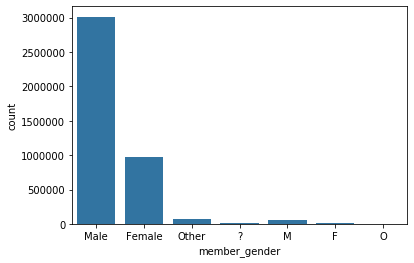

In [13]:
sb.countplot(data = df, x = 'member_gender', color = bc);

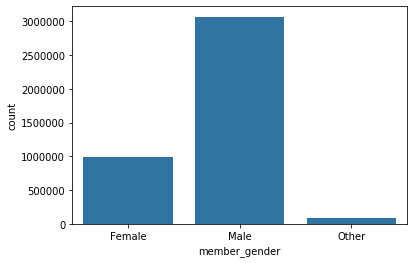

In [14]:
df.member_gender = df.member_gender.replace({'M': 'Male', 'F': 'Female', 'O': 'Other', '?': 'Other'})
df.member_gender = df.member_gender.astype('category')
sb.countplot(data = df, x = 'member_gender', color = bc);

After some relabeling, we have 3 categories for gender. We see 3 times as many rides made by males than females, which is out of line with [the Bay Area's demographics](http://www.bayareacensus.ca.gov/counties/SanFranciscoCounty.htm).

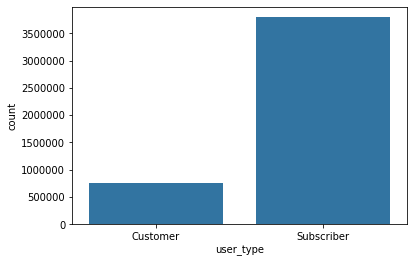

In [15]:
sb.countplot(data = df, x = 'user_type', color = bc);

In [16]:
df.user_type = df.user_type.astype('category')

Subscribers take many more rides than customers. This is an interesting point of inquiry. While we can't make too many assumptions, it's clear that the bike share is primarily used by repeat customers rather than casual customers.

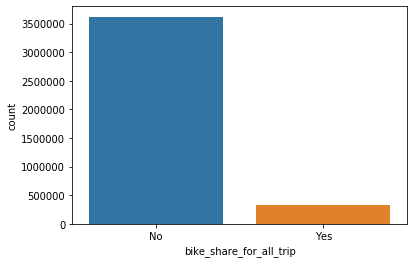

In [17]:
sb.countplot(data=df, x='bike_share_for_all_trip');

It's unclear what exactly `bike_share_for_all_trip` represents. It looks like less than 10% of the data has a value of `Yes` for the attribute. What's more, looking back at the [data definitions](https://www.lyft.com/bikes/bay-wheels/system-data), we don't even see this attribute described. Given the skew and lack of definition, this data doesn't appear to hold much value. In the interest of memory usage and performance, we'll drop this column for the rest of the analysis.

In [18]:
df.drop('bike_share_for_all_trip', axis=1, inplace=True)

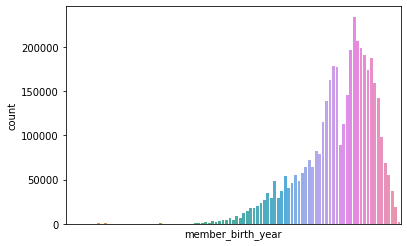

In [19]:
ax = sb.countplot(data=df, x='member_birth_year')
ax.set_xticks([]);

Member birth year is highly left skewed, which might be expected. This tracks both with [Bay Area demographics](http://www.bayareacensus.ca.gov/counties/SanFranciscoCounty.htm), and what we might expect from an activity that depends on physicality. We'll do a quick double-check of the value counts:

In [20]:
df.member_birth_year.value_counts()

1988    234172
1989    207045
1990    198413
1987    196202
1991    191347
         ...  
1930         3
1906         2
1903         1
1910         1
1919         1
Name: member_birth_year, Length: 97, dtype: int64

We'll provide a similar treatment for the start- and end-stations. We won't expect to learn too much, but the general shape of the data we'll help us gain some understanding about what we're dealing with.

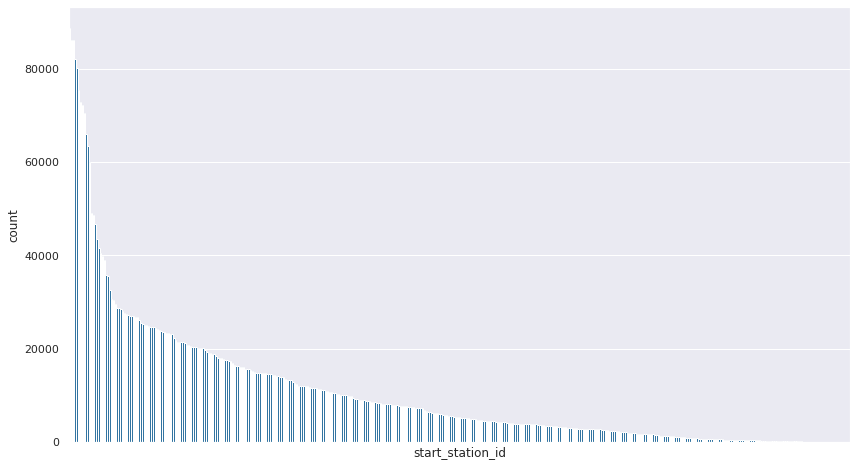

In [21]:
sb.set(rc={'figure.figsize':(14,8)})
start_ord = df['start_station_id'].value_counts().index
ax = sb.countplot(data = df, x = 'start_station_id', color = bc, order = start_ord)
ax.set_xticks([]);

In [22]:
df.start_station_name.value_counts()

San Francisco Ferry Building (Harry Bridges Plaza)           88833
San Francisco Caltrain Station 2  (Townsend St at 4th St)    86248
Market St at 10th St                                         86120
Berry St at 4th St                                           82050
San Francisco Caltrain (Townsend St at 4th St)               80227
                                                             ...  
Columbia Ave at Bird Ave                                         4
San Jose Depot                                                   3
19th St at William St                                            2
Brannan St at 7th St                                             2
SF Test Station                                                  1
Name: start_station_name, Length: 458, dtype: int64

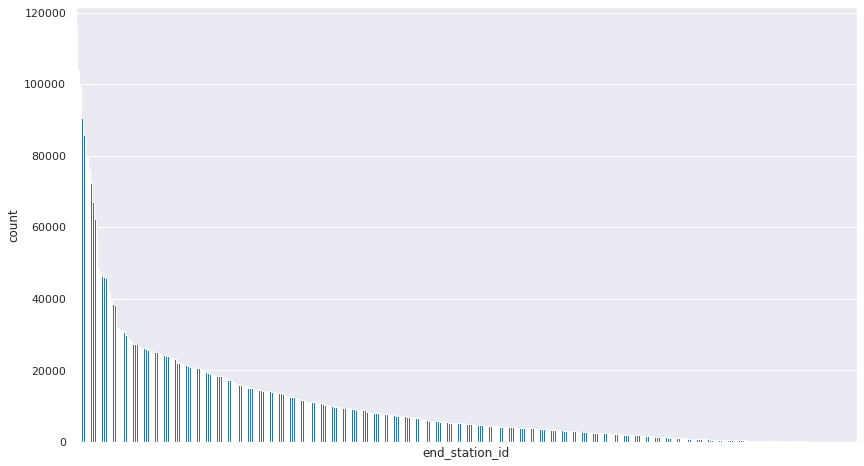

In [23]:
start_ord = df['end_station_id'].value_counts().index
ax = sb.countplot(data = df, x = 'end_station_id', color = bc, order = start_ord)
ax.set_xticks([]);

In [24]:
df.end_station_name.value_counts()

San Francisco Caltrain Station 2  (Townsend St at 4th St)    115804
San Francisco Ferry Building (Harry Bridges Plaza)           104061
San Francisco Caltrain (Townsend St at 4th St)                99510
Montgomery St BART Station (Market St at 2nd St)              90552
The Embarcadero at Sansome St                                 85649
                                                              ...  
Howard workshop - Station in a Box                                4
San Jose Depot                                                    2
Brannan St at 7th St                                              2
Emeryville Depot                                                  1
19th St at William St                                             1
Name: end_station_name, Length: 459, dtype: int64

For both start- and end-station, we see a large skew. This looks more logarithmic rather than a skewed normal distribution, however. It appears that there are a few stations that enjoy an extremely high frequency of usership, but after them, the frequency quickly levels off.

In [25]:
df.bike_id.value_counts()

2174      1967
2692      1964
1396      1927
3379      1883
1161      1882
          ... 
5777         1
289022       1
12501        1
5688         1
6271         1
Name: bike_id, Length: 11898, dtype: int64

In [26]:
df.bike_id.nunique()

11898

Like `bike_share_for_all_trip`, the `bike_id` attribute has questionable value. Presumably, it maps an ID to a particular bike, and not a user, judging by the count of unique values. (One expects that a city of San Francisco's size would have more than 12000 unique users over 2+ years). While this data might be useful for a fine-grained analysis, it seems out of scope here. We will again drop this to preserve system resources.

In [27]:
df.drop('bike_id', axis=1, inplace=True)

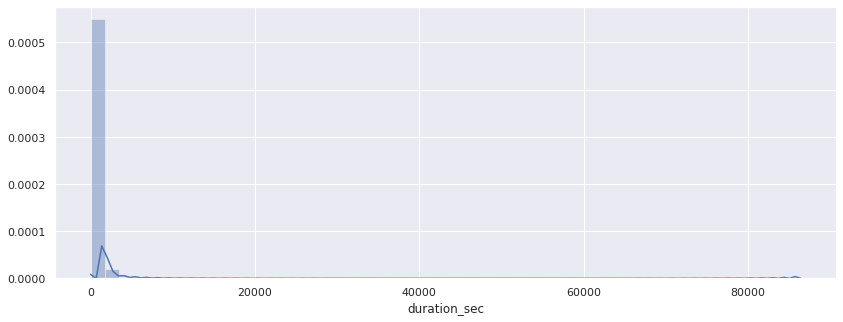

In [28]:
sb.set(rc={'figure.figsize':(14,5)})
sb.distplot(df['duration_sec']);

The trip duration data is too skewed to be easily visualized. We have vast bulk of the data at the low-end of the scale, combined with some extreme outliers. We'll bin the data, and zoom in on the far low end.

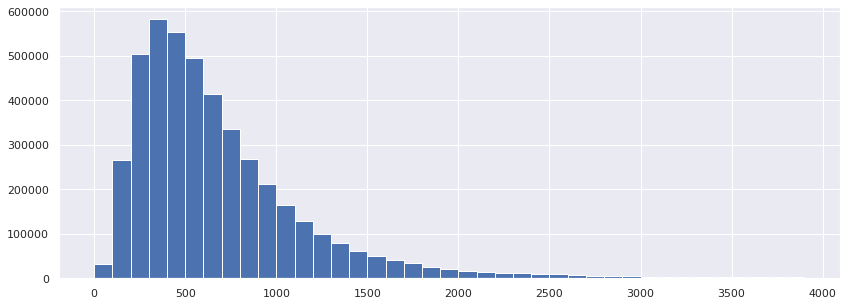

In [29]:
bins = np.arange(0, 4000, 100)
plt.hist(data=df, x='duration_sec', bins=bins);

Here we gain some more insight. There data is still right skewed, but we can see that most rides clock in around 6 minutes.

## Enhancing the Data
[back to contents](#Contents)

While we can learn some things about bike share ridership with the data as-is, some modifications may provide further insights. We can convert the latitude and longitude pairs into ride distances. Continuous values for age and ride-start times make it hard to generalize about these observations. We'll group them into broader categorical values. Finally, we'll convert values for `birth_year` and `duration_sec` into `age` and `duration_min`, which should make them easier for our audience to interpret.

In [30]:
#https://gist.github.com/rochacbruno/2883505
#https://engineering.upside.com/a-beginners-guide-to-optimizing-pandas-code-for-speed-c09ef2c6a4d6

def distance(start_lat, start_lon, end_lat, end_lon):
    radius = 6371 * 1000 # meters
    
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [start_lat, start_lon, end_lat, end_lon])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    d = radius * c

    return np.floor(d)

In [31]:
df['trip_distance'] = distance( df.start_station_latitude, df.start_station_longitude,
    df.end_station_latitude, df.end_station_longitude)

In [32]:
df.trip_distance.describe()

count    4.554806e+06
mean     1.726826e+03
std      3.284722e+04
min      0.000000e+00
25%      8.980000e+02
50%      1.413000e+03
75%      2.159000e+03
max      1.279835e+07
Name: trip_distance, dtype: float64

In [33]:
df[ df.trip_distance > 100000]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,user_type,member_birth_year,member_gender,trip_distance
1059576,7890,2019-07-24 09:29:16.000,2019-07-24 11:40:47.000,nan,NaN,37.789527,-122.401979,nan,NaN,36.739538,-121.469453,Subscriber,NaN,Other,142971.0
2568363,2365,2019-04-30 18:21:42.610,2019-04-30 19:01:08.146,50,2nd St at Townsend St,37.780526,-122.390288,420,SF Test Station,0.000000,0.000000,Subscriber,1995,Female,12792805.0
2569129,1964,2019-04-30 17:31:19.646,2019-04-30 18:04:04.518,98,Valencia St at 16th St,37.765052,-122.421866,420,SF Test Station,0.000000,0.000000,Subscriber,1981,Female,12796015.0
2569283,546,2019-04-30 17:45:38.452,2019-04-30 17:54:45.258,370,Jones St at Post St,37.787327,-122.413278,420,SF Test Station,0.000000,0.000000,Subscriber,1991,Female,12794414.0
2569362,630,2019-04-30 17:39:33.507,2019-04-30 17:50:04.314,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,420,SF Test Station,0.000000,0.000000,Subscriber,1991,Male,12793300.0
2569815,433,2019-04-30 17:17:10.486,2019-04-30 17:24:23.919,11,Davis St at Jackson St,37.797280,-122.398436,420,SF Test Station,0.000000,0.000000,Subscriber,1995,Male,12792797.0
2569898,1233,2019-04-30 16:58:41.209,2019-04-30 17:19:14.689,81,Berry St at 4th St,37.775880,-122.393170,420,SF Test Station,0.000000,0.000000,Subscriber,1970,Male,12793228.0
2569930,1306,2019-04-30 16:55:35.924,2019-04-30 17:17:22.162,80,Townsend St at 5th St,37.775235,-122.397437,420,SF Test Station,0.000000,0.000000,Subscriber,1992,Male,12793604.0
2570221,764,2019-04-30 16:44:12.351,2019-04-30 16:56:56.539,16,Steuart St at Market St,37.794130,-122.394430,420,SF Test Station,0.000000,0.000000,Customer,1976,Male,12792596.0
2582472,1491,2019-04-28 18:40:41.288,2019-04-28 19:05:33.063,377,Fell St at Stanyan St,37.771917,-122.453704,420,SF Test Station,0.000000,0.000000,Customer,1981,Male,12798346.0


There are several outliers here skewing the summary statistics. The main issue is that a number of observations seem to be test data, using either `SF Test Station` or `16th Depot Bike Station` as a starting or ending point. These stations have the prime meridian as a dummy value for latitude and longitude, which is throwing our distance measure way off. There is one other observation with a distance of greater than 100,000 meters, but with no start or end station. While an outlier, [this appears to be legitimate](https://goo.gl/maps/S3rYWtfU2e23H7VP6). We'll retain that observation in recognition of such an intrepid journey, but drop the test data (while admiring the Baywheels team's dedication to the Bay Area reputation in its choice of IDs).

In [34]:
# Western Hemisphere only
df = df[ (df.start_station_longitude != 0) & (df.end_station_longitude != 0) ]
df[ df.trip_distance > 100000]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,user_type,member_birth_year,member_gender,trip_distance
1059576,7890,2019-07-24 09:29:16,2019-07-24 11:40:47,nan,NaN,37.789527,-122.401979,nan,NaN,36.739538,-121.469453,Subscriber,NaN,Other,142971.0


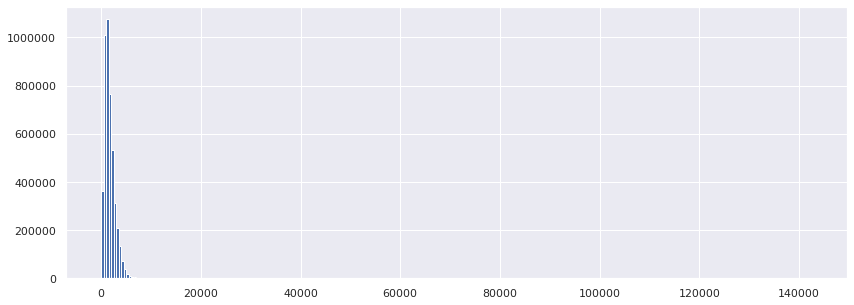

In [35]:
bins = np.arange(0, df.trip_distance.max() + 1, 500)
plt.hist(data=df, x='trip_distance', bins=bins);

Like `duration_sec`, we're seeing an extreme skew here. Again, we'll do some binning and narrow our scope.

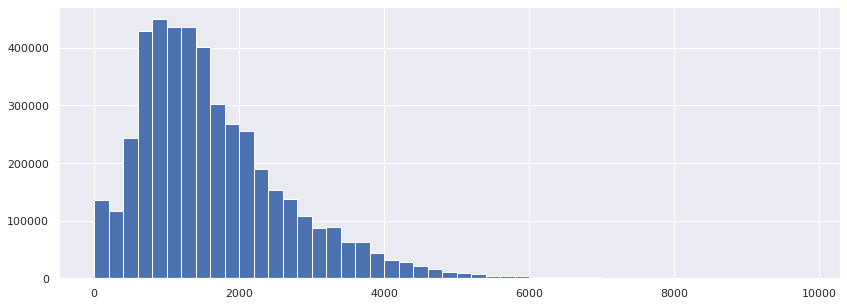

In [36]:
bins = np.arange(0, 10000, 200)
plt.hist(data=df, x='trip_distance', bins=bins);

Again we see a skewed normal distribution, with most rides coming in around 1 kilometer, or slightly more than a half mile. This seems about right: most rides within a short distance, with some extra-large outliers.

In [37]:
df[ df.start_time.dt.year < 2018 ]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,user_type,member_birth_year,member_gender,trip_distance
0,80110,2017-12-31 16:57:39.654,2018-01-01 15:12:50.245,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,Customer,1987,Male,942.0
1,78800,2017-12-31 15:56:34.842,2018-01-01 13:49:55.617,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,Customer,1965,Female,3069.0
2,45768,2017-12-31 22:45:48.411,2018-01-01 11:28:36.883,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,Customer,NaN,NaN,0.0
3,62172,2017-12-31 17:31:10.636,2018-01-01 10:47:23.531,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,Customer,NaN,NaN,1046.0
4,43603,2017-12-31 14:23:14.001,2018-01-01 02:29:57.571,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,Subscriber,1997,Female,636.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519695,435,2017-06-28 10:00:54.528,2017-06-28 10:08:10.438,81,Berry St at 4th St,37.775880,-122.393170,45,5th St at Howard St,37.781752,-122.405127,Subscriber,1991,Male,1237.0
519696,431,2017-06-28 09:56:39.631,2017-06-28 10:03:51.090,66,3rd St at Townsend St,37.778742,-122.392741,321,5th at Folsom,37.780146,-122.403071,Subscriber,1973,Male,921.0
519697,424,2017-06-28 09:47:36.347,2017-06-28 09:54:41.187,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,48,2nd St at S Park St,37.782411,-122.392706,Subscriber,1985,Female,1072.0
519698,366,2017-06-28 09:47:41.664,2017-06-28 09:53:47.715,58,Market St at 10th St,37.776619,-122.417385,59,S Van Ness Ave at Market St,37.774814,-122.418954,Subscriber,1981,Male,243.0


In [38]:
df[ df.start_time.dt.year < 2018 ].start_time.dt.month.value_counts()

10    108937
9      98558
11     95612
12     86539
8      83292
7      44073
6       2689
Name: start_time, dtype: int64

We see that the data for 2017 covers half the year, starting in June. Otherwise this looks fine, so we can feel confident including this dataset without further intervention. We'll cleanup the continuous variables, and add our categories.

In [39]:
df['ride_date'] = df.start_time.dt.floor('d')
df['duration_min'] = df.duration_sec // 60
df['member_age'] = df.start_time.dt.year - df.member_birth_year

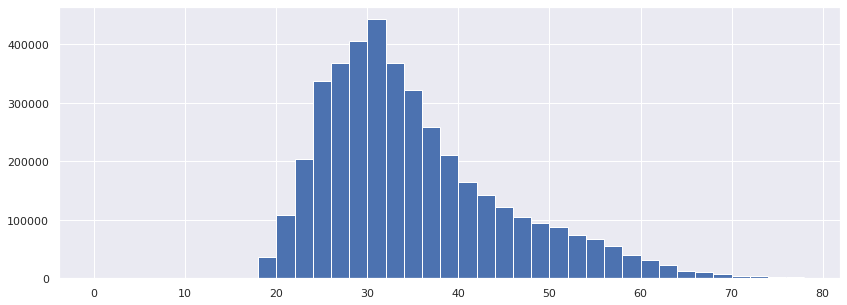

In [40]:
bins = np.arange(0, 80, 2)
plt.hist(df.member_age.astype('float'), bins=bins);

We see the same skewed distribution as before. Here, age values are clustered around the early 30s.

Now, we'll divide up the ride times into periods of the day, oriented around morning and evevning commutes.

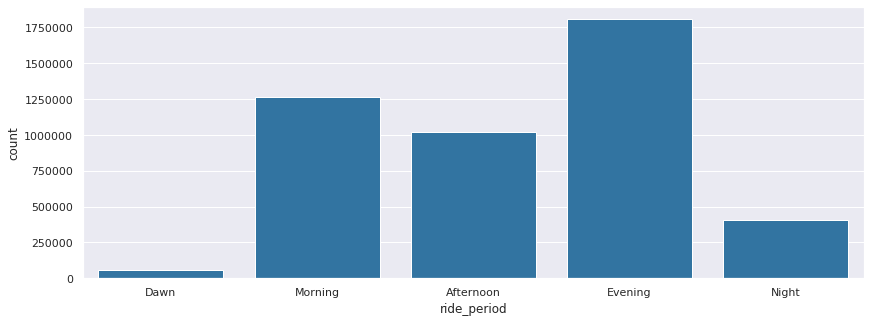

In [41]:
df['ride_period'] = pd.cut(df.start_time.dt.hour,
                           bins=[-1,4,9,14,19,24],
                           labels=['Dawn','Morning','Afternoon','Evening','Night'] )
sb.countplot(data = df, x = 'ride_period', color = bc);

`Dawn` isn't providing much help, so we'll lump that in with `Night`. Our new distribution suggests that the bike share is being used for daily commutes, with highs in the morning and evening, and dips in the afternoon and night.

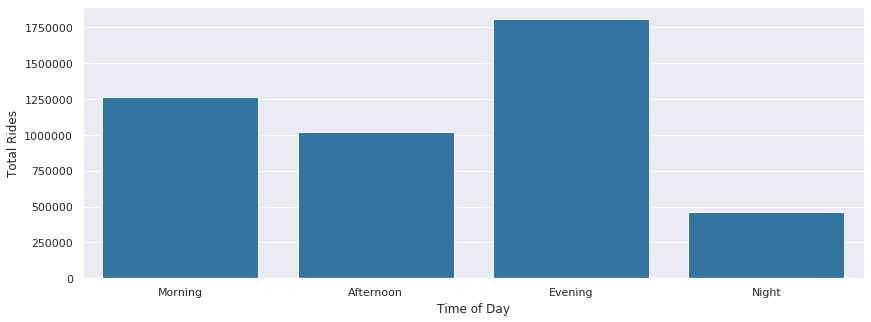

In [42]:
df['ride_period'] = df.ride_period.replace({'Dawn': 'Night'})
ax = sb.countplot(data = df, x = 'ride_period',
                  order=['Morning', 'Afternoon', 'Evening', 'Night'], color = bc)
ax.set_ylabel('Total Rides')
ax.set_xlabel('Time of Day');

In [43]:
df.ride_period = df.ride_period.astype('category')
df.ride_period.cat.remove_unused_categories(inplace=True)
df.ride_period

0            Evening
1            Evening
2              Night
3            Evening
4          Afternoon
             ...    
4554801        Night
4554802        Night
4554803        Night
4554804        Night
4554805        Night
Name: ride_period, Length: 4554776, dtype: category
Categories (4, object): [Afternoon, Evening, Morning, Night]

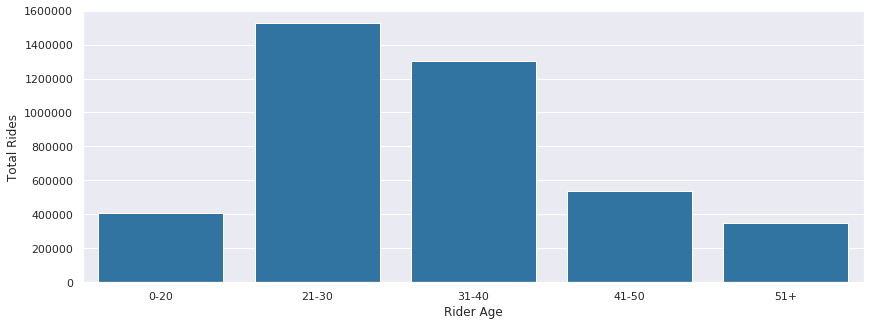

In [44]:
df['age_group'] = pd.cut(df.member_age,
                           bins=[0,20,30,40,50,10000],
                           labels=['0-20','21-30','31-40','41-50','51+'] )
ax = sb.countplot(data=df, x='age_group', color=bc)
ax.set_ylabel('Total Rides')
ax.set_xlabel('Rider Age');

This mirrors the distribution we saw earlier. It's tempting to split the `21-30` group up into `0-24` and `25-30`, but I retained the 10-year bins to keep comparison consistent across groups.

Seeing that ridership aligns with commute time, we'll also investigate weekday vs. weekend rides.

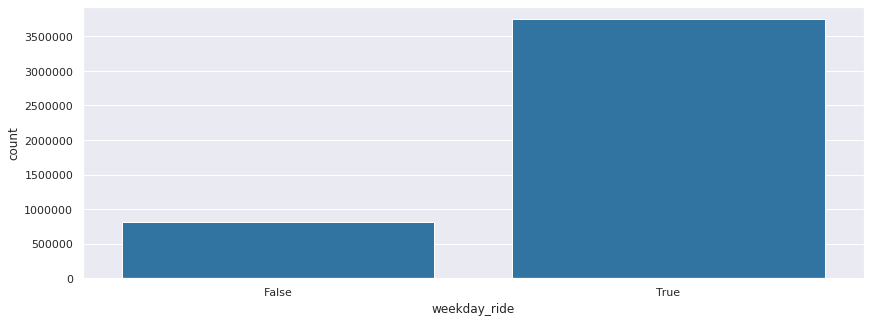

In [45]:
df['weekday_ride'] = df.ride_date.dt.dayofweek < 5
sb.countplot(data=df, x='weekday_ride', color=bc);

The division between weekday and weekend ridership agrees with the other evidence: commuters seem to be using the bike share more than casual users.

We'll drop columns we're no longer using, and save our enhanced data in 3 datasets separated by year.

In [46]:
df.drop(['duration_sec', 'start_time','end_time','member_birth_year'], axis=1, inplace=True)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4554776 entries, 0 to 4554805
Data columns (total 17 columns):
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
user_type                  category
member_gender              category
trip_distance              float64
ride_date                  datetime64[ns]
duration_min               int64
member_age                 Int64
ride_period                category
age_group                  category
weekday_ride               bool
dtypes: Int64(1), bool(1), category(4), datetime64[ns](1), float64(5), int64(1), object(4)
memory usage: 477.8+ MB


In [48]:
df_2017 = df[ df.ride_date.dt.year == 2017 ]
df_2017.head()

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,user_type,member_gender,trip_distance,ride_date,duration_min,member_age,ride_period,age_group,weekday_ride
0,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,Customer,Male,942.0,2017-12-31,1335,30,Evening,21-30,False
1,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,Customer,Female,3069.0,2017-12-31,1313,52,Evening,51+,False
2,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,Customer,NaN,0.0,2017-12-31,762,NaN,Night,NaN,False
3,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,Customer,NaN,1046.0,2017-12-31,1036,NaN,Evening,NaN,False
4,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,Subscriber,Female,636.0,2017-12-31,726,20,Afternoon,0-20,False


In [49]:
df_2018 = df[ df.ride_date.dt.year == 2018 ]
df_2018.head()

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,user_type,member_gender,trip_distance,ride_date,duration_min,member_age,ride_period,age_group,weekday_ride
701863,4,Cyril Magnin St at Ellis St,37.785881,-122.408915,4,Cyril Magnin St at Ellis St,37.785881,-122.408915,Customer,NaN,0.0,2018-04-30,1206,NaN,Night,NaN,True
701864,122,19th St at Mission St,37.760299,-122.418892,42,San Francisco City Hall (Polk St at Grove St),37.778650,-122.418230,Customer,NaN,2041.0,2018-04-30,1350,NaN,Evening,NaN,True
701865,41,Golden Gate Ave at Polk St,37.781270,-122.418740,67,San Francisco Caltrain Station 2 (Townsend St...,37.776639,-122.395526,Subscriber,Male,2104.0,2018-04-30,1435,44,Evening,0-20,True
701866,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,115,Jackson Playground,37.765026,-122.398773,Customer,Female,2214.0,2018-04-30,1147,44,Evening,21-30,True
701867,196,Grand Ave at Perkins St,37.808894,-122.256460,233,12th St at 4th Ave,37.795812,-122.255555,Customer,Male,1456.0,2018-04-30,984,53,Evening,51+,True


In [50]:
df_2019 = df[ df.ride_date.dt.year == 2019 ]
df_2019.head()

,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,user_type,member_gender,trip_distance,ride_date,duration_min,member_age,ride_period,age_group,weekday_ride
519700,321,5th St at Folsom,37.780146,-122.403071,60,8th St at Ringold St,37.774520,-122.409449,Customer,Female,839.0,2019-05-31,814,29,Night,21-30,True
519701,246,Berkeley Civic Center,37.869060,-122.270556,266,Parker St at Fulton St,37.862464,-122.264791,Subscriber,Male,891.0,2019-05-31,784,25,Evening,21-30,True
519702,149,Emeryville Town Hall,37.831275,-122.285633,149,Emeryville Town Hall,37.831275,-122.285633,Customer,Male,0.0,2019-05-31,98,31,Night,31-40,True
519703,186,Lakeside Dr at 14th St,37.801319,-122.262642,186,Lakeside Dr at 14th St,37.801319,-122.262642,Customer,Male,0.0,2019-05-31,43,21,Night,21-30,True
519704,34,Father Alfred E Boeddeker Park,37.783988,-122.412408,368,Myrtle St at Polk St,37.785434,-122.419622,Subscriber,Male,654.0,2019-05-31,70,52,Night,51+,True


In [51]:
df_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519700 entries, 0 to 519699
Data columns (total 17 columns):
start_station_id           519700 non-null object
start_station_name         519700 non-null object
start_station_latitude     519700 non-null float64
start_station_longitude    519700 non-null float64
end_station_id             519700 non-null object
end_station_name           519700 non-null object
end_station_latitude       519700 non-null float64
end_station_longitude      519700 non-null float64
user_type                  519700 non-null category
member_gender              453238 non-null category
trip_distance              519700 non-null float64
ride_date                  519700 non-null datetime64[ns]
duration_min               519700 non-null int64
member_age                 453159 non-null Int64
ride_period                519700 non-null category
age_group                  453159 non-null category
weekday_ride               519700 non-null bool
dtypes: Int64(1), bool

In [52]:
df_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1863721 entries, 701863 to 4298506
Data columns (total 17 columns):
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
user_type                  category
member_gender              category
trip_distance              float64
ride_date                  datetime64[ns]
duration_min               int64
member_age                 Int64
ride_period                category
age_group                  category
weekday_ride               bool
dtypes: Int64(1), bool(1), category(4), datetime64[ns](1), float64(5), int64(1), object(4)
memory usage: 195.5+ MB


In [53]:
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2171355 entries, 519700 to 4554805
Data columns (total 17 columns):
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
user_type                  category
member_gender              category
trip_distance              float64
ride_date                  datetime64[ns]
duration_min               int64
member_age                 Int64
ride_period                category
age_group                  category
weekday_ride               bool
dtypes: Int64(1), bool(1), category(4), datetime64[ns](1), float64(5), int64(1), object(4)
memory usage: 227.8+ MB


In [54]:
pd.to_pickle(df_2017, 'data/enhanced_data_2017.pkl.zip')

In [55]:
pd.to_pickle(df_2018, 'data/enhanced_data_2018.pkl.zip')

In [56]:
pd.to_pickle(df_2019, 'data/enhanced_data_2019.pkl.zip')

In [57]:
del df
del df_2017
del df_2018
del df_2019

## Time Series Analysis
[back to contents](#Contents)

In [58]:
df_2017 = pd.read_pickle('data/enhanced_data_2017.pkl.zip')
df_2017.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 519700 entries, 0 to 519699
Data columns (total 17 columns):
start_station_id           519700 non-null object
start_station_name         519700 non-null object
start_station_latitude     519700 non-null float64
start_station_longitude    519700 non-null float64
end_station_id             519700 non-null object
end_station_name           519700 non-null object
end_station_latitude       519700 non-null float64
end_station_longitude      519700 non-null float64
user_type                  519700 non-null category
member_gender              453238 non-null category
trip_distance              519700 non-null float64
ride_date                  519700 non-null datetime64[ns]
duration_min               519700 non-null int64
member_age                 453159 non-null Int64
ride_period                519700 non-null category
age_group                  453159 non-null category
weekday_ride               519700 non-null bool
dtypes: Int64(1), bool

In [59]:
df_2018 = pd.read_pickle('data/enhanced_data_2018.pkl.zip')
df_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1863721 entries, 701863 to 4298506
Data columns (total 17 columns):
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
user_type                  category
member_gender              category
trip_distance              float64
ride_date                  datetime64[ns]
duration_min               int64
member_age                 Int64
ride_period                category
age_group                  category
weekday_ride               bool
dtypes: Int64(1), bool(1), category(4), datetime64[ns](1), float64(5), int64(1), object(4)
memory usage: 195.5+ MB


In [60]:
df_2019 = pd.read_pickle('data/enhanced_data_2019.pkl.zip')
df_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2171355 entries, 519700 to 4554805
Data columns (total 17 columns):
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
user_type                  category
member_gender              category
trip_distance              float64
ride_date                  datetime64[ns]
duration_min               int64
member_age                 Int64
ride_period                category
age_group                  category
weekday_ride               bool
dtypes: Int64(1), bool(1), category(4), datetime64[ns](1), float64(5), int64(1), object(4)
memory usage: 227.8+ MB


We'll begin by analyzing the average duration and distance of rides each day for each year, 2017-2019.

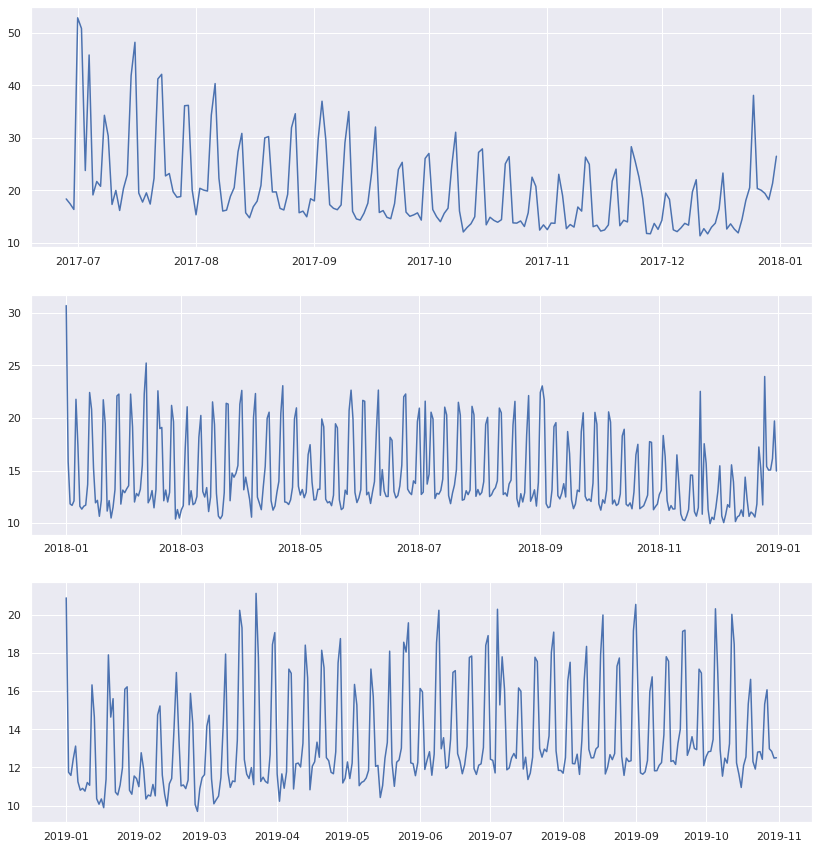

In [61]:
fig, axes = plt.subplots(3, 1, figsize=(14,15))
axes[0].plot(df_2017.groupby('ride_date')['duration_min'].mean())
axes[1].plot(df_2018.groupby('ride_date')['duration_min'].mean())
axes[2].plot(df_2019.groupby('ride_date')['duration_min'].mean());

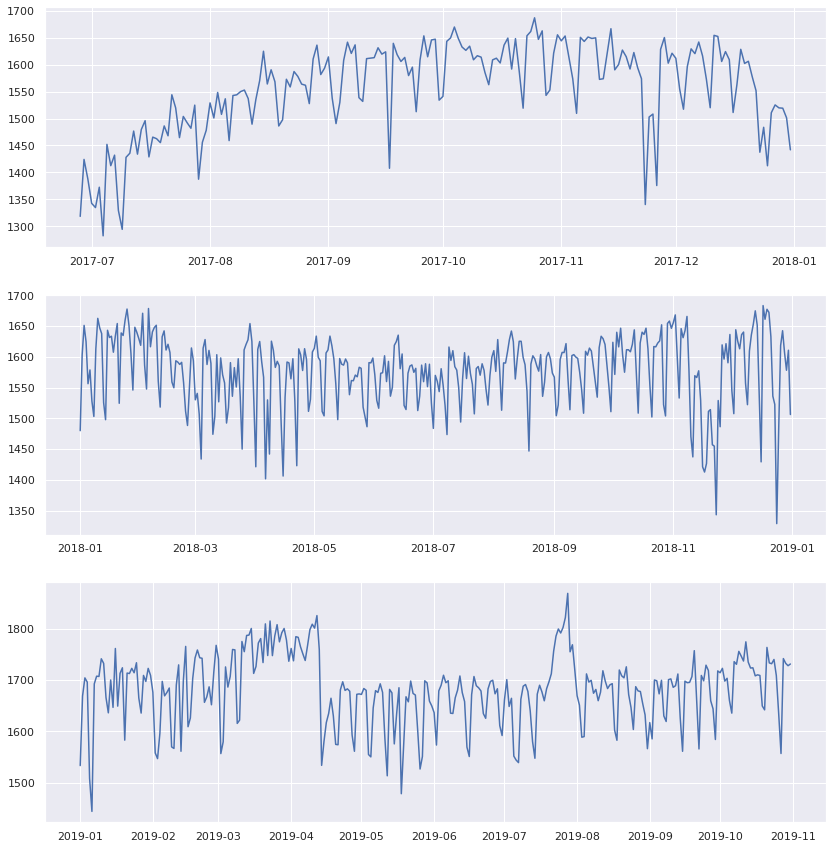

In [62]:
fig, axes = plt.subplots(3, 1, figsize=(14,15))
axes[0].plot(df_2017.groupby('ride_date')['trip_distance'].mean())
axes[1].plot(df_2018.groupby('ride_date')['trip_distance'].mean())
axes[2].plot(df_2019.groupby('ride_date')['trip_distance'].mean());

There's a lot of fluctuation day by day, which is making the graphs difficult to read. Instead, we'll take a weekly, rolling average for each year.

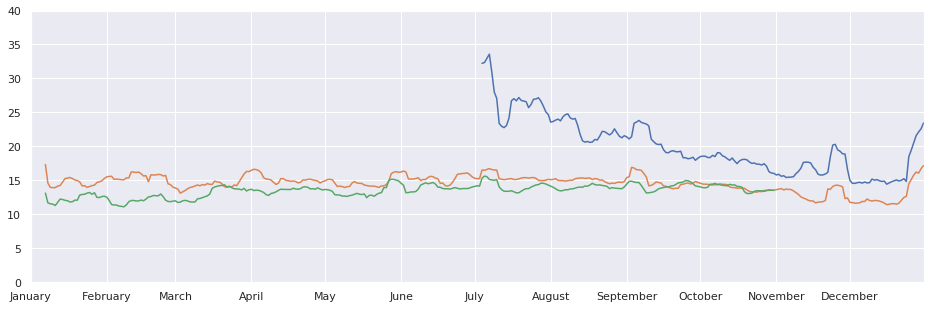

In [63]:
fig, ax = plt.subplots(figsize=(16,5))
days = mdates.DayLocator(bymonthday=[8,15,22])
months = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%B')

ax.set_xlim(1, 365)
ax.set_ylim(0, 40)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(month_fmt)
ax.xaxis.set_minor_locator(days)
ax.plot(df_2017.groupby(df_2017['ride_date'].dt.dayofyear)['duration_min'].mean().rolling(7).mean())
ax.plot(df_2018.groupby(df_2018['ride_date'].dt.dayofyear)['duration_min'].mean().rolling(7).mean())
ax.plot(df_2019.groupby(df_2019['ride_date'].dt.dayofyear)['duration_min'].mean().rolling(7).mean());

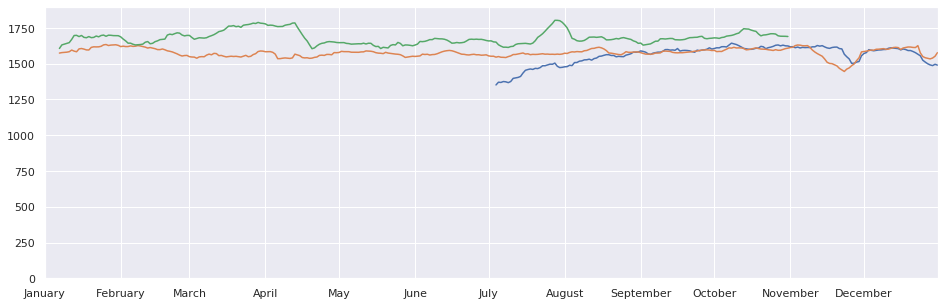

In [64]:
fig, ax = plt.subplots(figsize=(16,5))
days = mdates.DayLocator(bymonthday=[8,15,22])
months = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%B')

ax.set_xlim(1, 365)
ax.set_ylim(0, 1900)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(month_fmt)
ax.xaxis.set_minor_locator(days)
ax.plot(df_2017.groupby(df_2017['ride_date'].dt.dayofyear)['trip_distance'].mean().rolling(7).mean())
ax.plot(df_2018.groupby(df_2018['ride_date'].dt.dayofyear)['trip_distance'].mean().rolling(7).mean())
ax.plot(df_2019.groupby(df_2019['ride_date'].dt.dayofyear)['trip_distance'].mean().rolling(7).mean());

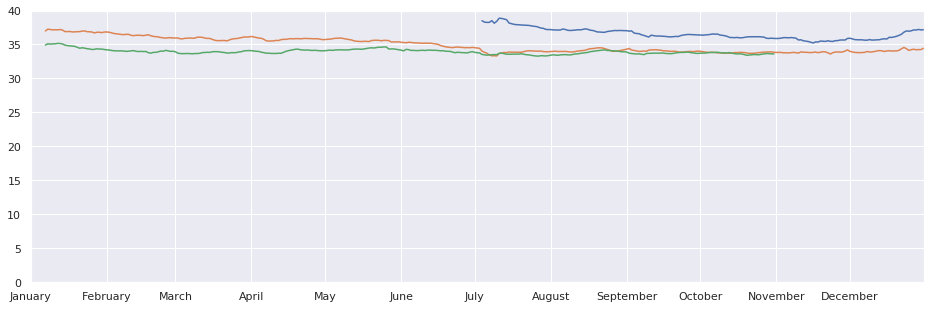

In [65]:
fig, ax = plt.subplots(figsize=(16,5))
days = mdates.DayLocator(bymonthday=[8,15,22])
months = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%B')

ax.set_xlim(1, 365)
ax.set_ylim(0, 40)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(month_fmt)
ax.xaxis.set_minor_locator(days)
ax.plot(df_2017.groupby(df_2017['ride_date'].dt.dayofyear)['member_age'].mean().rolling(7).mean())
ax.plot(df_2018.groupby(df_2018['ride_date'].dt.dayofyear)['member_age'].mean().rolling(7).mean())
ax.plot(df_2019.groupby(df_2019['ride_date'].dt.dayofyear)['member_age'].mean().rolling(7).mean());

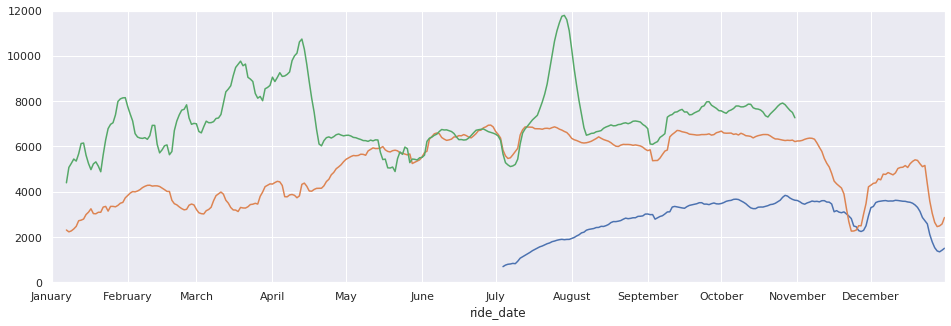

In [66]:
fig, ax = plt.subplots(figsize=(16,5))
days = mdates.DayLocator(bymonthday=[8,15,22])
months = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%B')

ax.set_xlim(1, 365)
ax.set_ylim(0, 12000)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(month_fmt)
ax.xaxis.set_minor_locator(days)
df_2017.groupby(df_2017['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean().plot(ax=ax)
df_2018.groupby(df_2018['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean().plot(ax=ax)
df_2019.groupby(df_2019['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean().plot(ax=ax);

The rolling averages show some interesting trends, and one I didn't expect. The number of daily rides has steadily increased over the past 2.5 years. That was expected; what's unexpected is how little the other data changed over the same time. Ride duration, distance, and rider age all quickly stablized, then show little variation afterwards. This is especially interesting given that ridership is increasing over that same time. So, the bike share is being used more and more, but by the same people, and in the same ways.

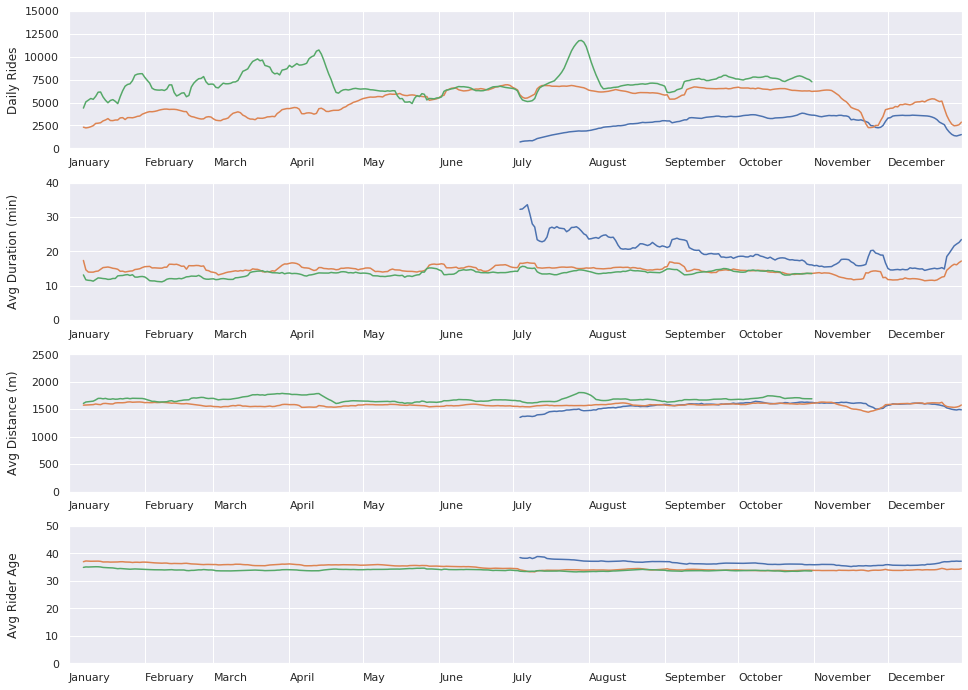

In [67]:
fig, axes = plt.subplots(4, 1, figsize=(16,12))

for ax in axes:
    days = mdates.DayLocator(bymonthday=[8,15,22])
    months = mdates.MonthLocator()
    month_fmt = mdates.DateFormatter('%B')
    
    ax.set_xlim(1, 365)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(month_fmt)
    ax.xaxis.set_minor_locator(days)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_horizontalalignment('left')

# Total Rides
axes[0].set_ylim(0, 15000)
axes[0].set_ylabel("Daily Rides")
axes[0].plot(df_2017.groupby(df_2017['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean())
axes[0].plot(df_2018.groupby(df_2018['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean())
axes[0].plot(df_2019.groupby(df_2019['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean())

# Ride Duration
axes[1].set_ylim(0, 40)
axes[1].set_ylabel("Avg Duration (min)")
axes[1].plot(df_2017.groupby(df_2017['ride_date'].dt.dayofyear)['duration_min'].mean().rolling(7).mean())
axes[1].plot(df_2018.groupby(df_2018['ride_date'].dt.dayofyear)['duration_min'].mean().rolling(7).mean())
axes[1].plot(df_2019.groupby(df_2019['ride_date'].dt.dayofyear)['duration_min'].mean().rolling(7).mean())

# Ride Distance
axes[2].set_ylim(0, 2500)
axes[2].set_ylabel("Avg Distance (m)")
axes[2].plot(df_2017.groupby(df_2017['ride_date'].dt.dayofyear)['trip_distance'].mean().rolling(7).mean())
axes[2].plot(df_2018.groupby(df_2018['ride_date'].dt.dayofyear)['trip_distance'].mean().rolling(7).mean())
axes[2].plot(df_2019.groupby(df_2019['ride_date'].dt.dayofyear)['trip_distance'].mean().rolling(7).mean())

# Rider Age
axes[3].set_ylim(0, 50)
axes[3].set_ylabel("Avg Rider Age")
axes[3].plot(df_2017.groupby(df_2017['ride_date'].dt.dayofyear)['member_age'].mean().rolling(7).mean())
axes[3].plot(df_2018.groupby(df_2018['ride_date'].dt.dayofyear)['member_age'].mean().rolling(7).mean())
axes[3].plot(df_2019.groupby(df_2019['ride_date'].dt.dayofyear)['member_age'].mean().rolling(7).mean())

fig.align_ylabels()
fig.subplots_adjust(hspace=0.25);

This data is surprising enough that I think it makes sense to double check some of these distributions. We'll join the dataframes, add a new column for year, and plot the individual distributions by year.

In [88]:
df = pd.concat([df_2017,df_2018,df_2019])
df['ride_year'] = df.ride_date.dt.year

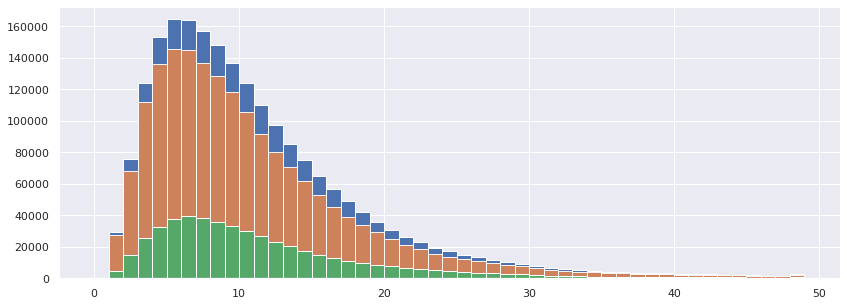

In [93]:
bins = np.arange(0,50,1)
plt.hist(df[ df.ride_year == 2019].duration_min, bins=bins)
plt.hist(df[ df.ride_year == 2018].duration_min, bins=bins, alpha=0.9)
plt.hist(df[ df.ride_year == 2017].duration_min, bins=bins);

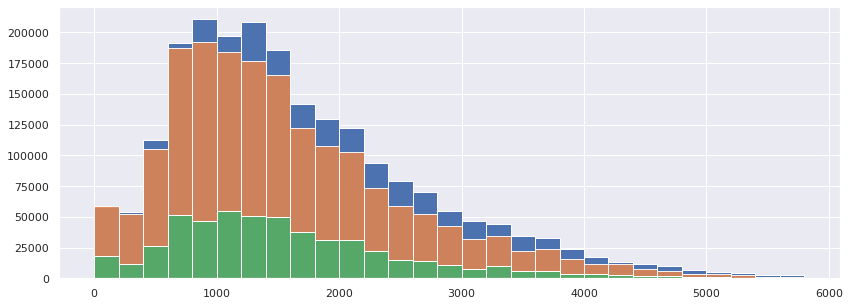

In [110]:
bins = np.arange(0,6000,200)
plt.hist(df[ df.ride_year == 2019].trip_distance, bins=bins)
plt.hist(df[ df.ride_year == 2018].trip_distance, bins=bins, alpha=0.9)
plt.hist(df[ df.ride_year == 2017].trip_distance, bins=bins);

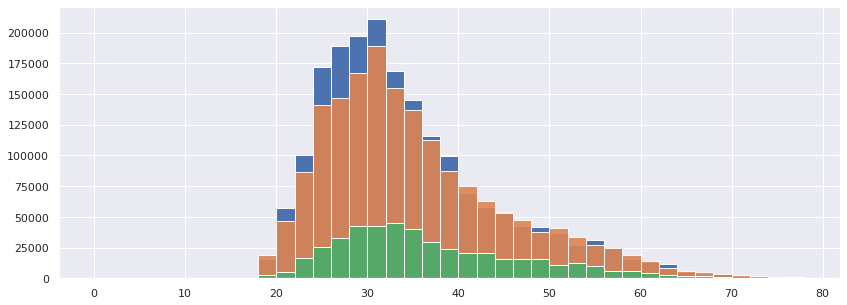

In [95]:
bins = np.arange(0,80,2)
plt.hist(df[ df.ride_year == 2019].member_age.astype('float'), bins=bins)
plt.hist(df[ df.ride_year == 2018].member_age.astype('float'), bins=bins, alpha=0.9)
plt.hist(df[ df.ride_year == 2017].member_age.astype('float'), bins=bins);

The histograms agree with our rolling averages. While there are some outliers, age, duration, and distance all show string central tendencies. Additionally, these tendecies are consistent from year to year.

## Faceting
[back to contents](#Contents)

Having examined the time series data, we'll do a pairwise examination of some of our categorical variables.

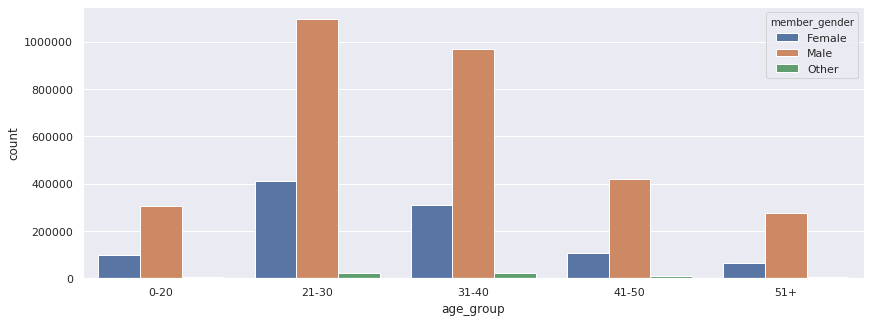

In [121]:
sb.countplot(data=df, x='age_group', hue='member_gender');

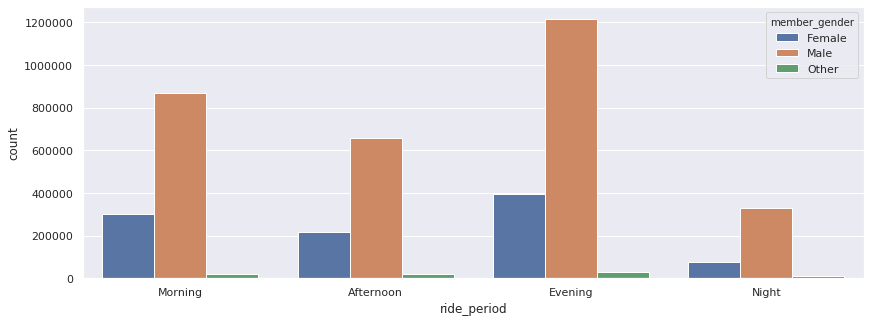

In [122]:
sb.countplot(data=df, x='ride_period', hue='member_gender',
             order=['Morning', 'Afternoon', 'Evening', 'Night']);

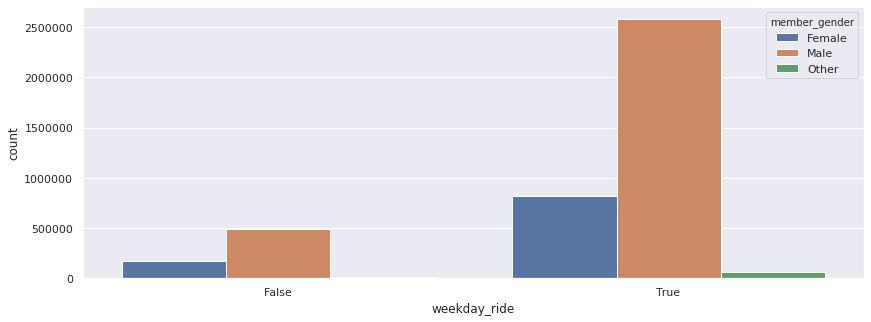

In [123]:
sb.countplot(data=df, x='weekday_ride', hue='member_gender');

Looking at usage by gender, the data looks fairly consistent. The facets vary in similar ways, with many more `Male` riders than `Female` or `Other`.

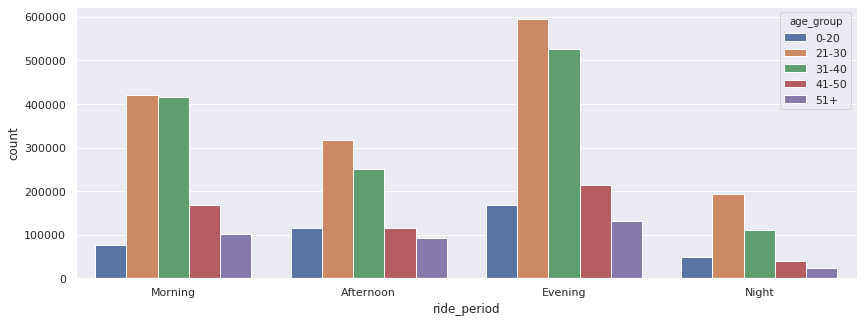

In [124]:
sb.countplot(data=df, x='ride_period', hue='age_group',
             order=['Morning', 'Afternoon', 'Evening', 'Night']);

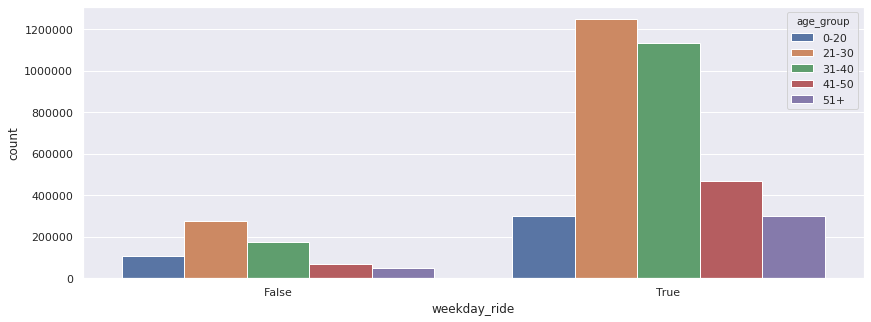

In [127]:
sb.countplot(data=df, x='weekday_ride', hue='age_group');

Faceting by age group reveals one interesting bit of information. Usage by the youngest riders breaks the general pattern, increasing from morning, afternoon, to evening. Presumably, these riders aren't using the bike share to commute. This supports our reading of the data thus far.

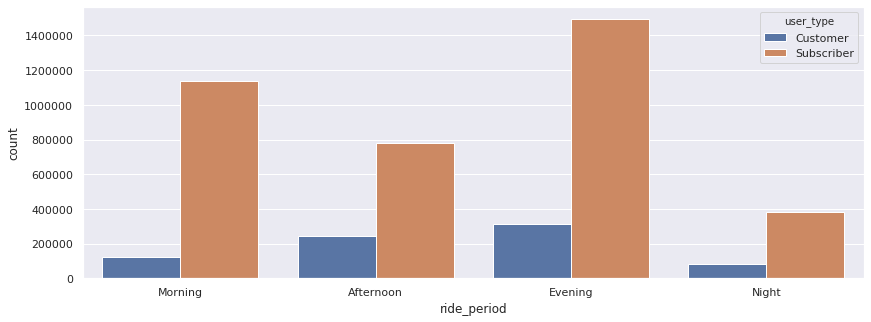

In [128]:
sb.countplot(data=df, x='ride_period', hue='user_type',
             order=['Morning', 'Afternoon', 'Evening', 'Night']);

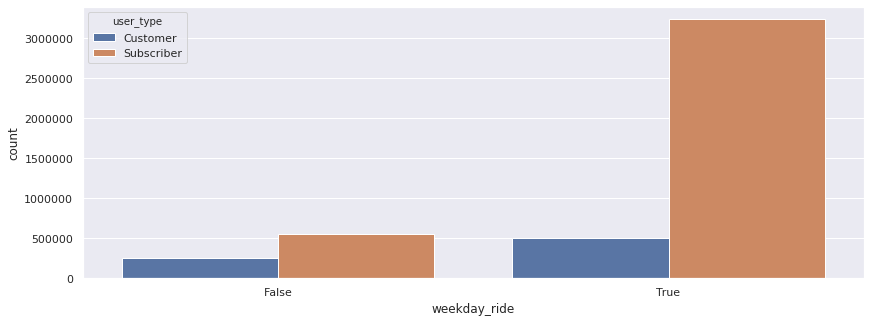

In [129]:
sb.countplot(data=df, x='weekday_ride', hue='user_type');

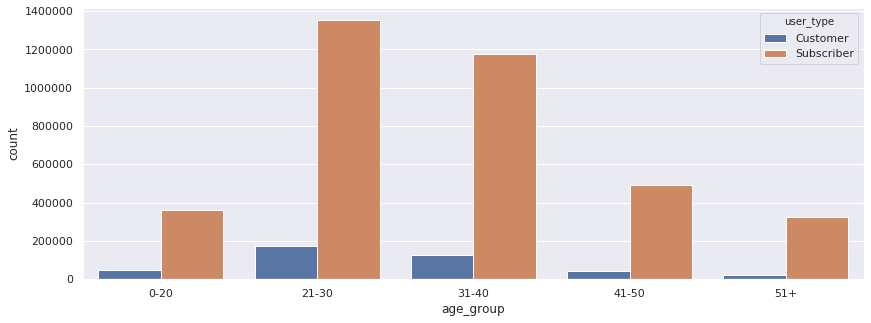

In [75]:
sb.countplot(data=df, x='age_group', hue='user_type');

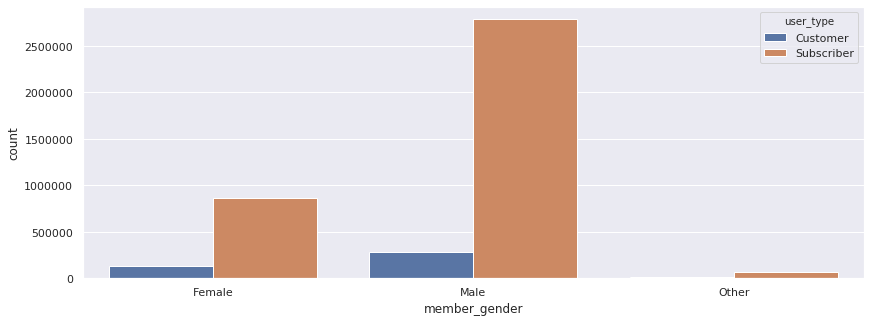

In [133]:
sb.countplot(data=df, x='member_gender', hue='user_type');

We gain more insight faceting by `user_type`. We see subscribers using the bike share in a commuter pattern: mornings and evenings, on weekdays. Customers show a different pattern: steadily increasing throughout the day, and more evenly divided between weekends and weekdays.

With this knowledge, let's reexamine the time trends and see if we can learn something new.

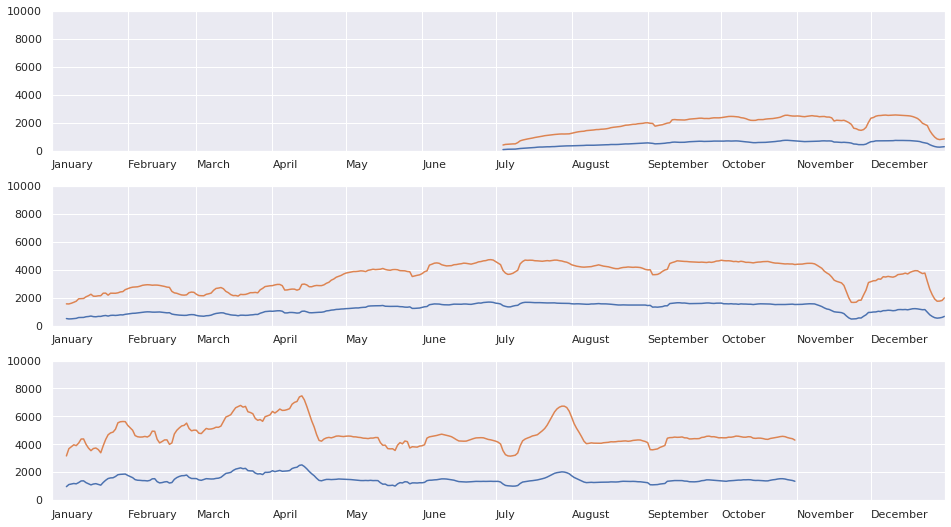

In [77]:
fig, axes = plt.subplots(3, 1, figsize=(16,9))

for ax in axes:
    days = mdates.DayLocator(bymonthday=[8,15,22])
    months = mdates.MonthLocator()
    month_fmt = mdates.DateFormatter('%B')
    
    ax.set_xlim(1, 365)
    ax.set_ylim(0, 10000)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(month_fmt)
    ax.xaxis.set_minor_locator(days)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_horizontalalignment('left')


axes[0].plot(df_2017[df_2017.member_gender == 'Female'].groupby(df_2017['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());
axes[0].plot(df_2017[df_2017.member_gender == 'Male'].groupby(df_2017['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());

axes[1].plot(df_2018[df_2018.member_gender == 'Female'].groupby(df_2018['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());
axes[1].plot(df_2018[df_2018.member_gender == 'Male'].groupby(df_2018['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());

axes[2].plot(df_2019[df_2019.member_gender == 'Female'].groupby(df_2019['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());
axes[2].plot(df_2019[df_2019.member_gender == 'Male'].groupby(df_2019['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());

fig.align_ylabels()
fig.subplots_adjust(hspace=0.25);

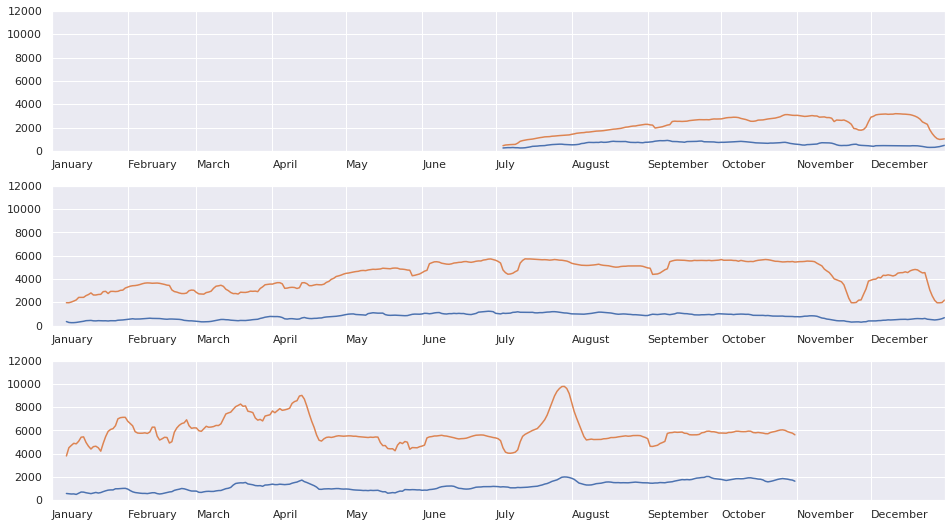

In [78]:
fig, axes = plt.subplots(3, 1, figsize=(16,9))

for ax in axes:
    days = mdates.DayLocator(bymonthday=[8,15,22])
    months = mdates.MonthLocator()
    month_fmt = mdates.DateFormatter('%B')
    
    ax.set_xlim(1, 365)
    ax.set_ylim(0, 12000)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(month_fmt)
    ax.xaxis.set_minor_locator(days)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_horizontalalignment('left')


axes[0].plot(df_2017[df_2017.user_type == 'Customer'].groupby(df_2017['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());
axes[0].plot(df_2017[df_2017.user_type == 'Subscriber'].groupby(df_2017['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());

axes[1].plot(df_2018[df_2018.user_type == 'Customer'].groupby(df_2018['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());
axes[1].plot(df_2018[df_2018.user_type == 'Subscriber'].groupby(df_2018['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());

axes[2].plot(df_2019[df_2019.user_type == 'Customer'].groupby(df_2019['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());
axes[2].plot(df_2019[df_2019.user_type == 'Subscriber'].groupby(df_2019['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());

fig.align_ylabels()
fig.subplots_adjust(hspace=0.25);

While ridership is growing for males and females, it's growing at a faster rate for males. Additionally, growth in ridership tracks with growth in subscriber usage; casual usage is mostly flat. It seems that the bike share program appeals to a specific demographic, which explains the lack of variation we saw previously. Finally, we'll take a look at the Customer/Subscriber-Male/Female split.

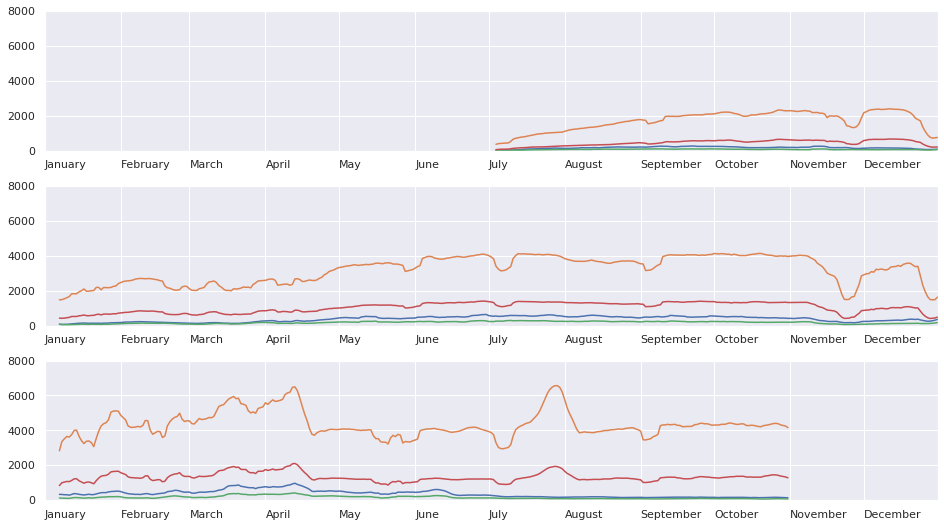

In [139]:
fig, axes = plt.subplots(3, 1, figsize=(16,9))

for ax in axes:
    days = mdates.DayLocator(bymonthday=[8,15,22])
    months = mdates.MonthLocator()
    month_fmt = mdates.DateFormatter('%B')
    
    ax.set_xlim(1, 365)
    ax.set_ylim(0, 8000)
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(month_fmt)
    ax.xaxis.set_minor_locator(days)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_horizontalalignment('left')


axes[0].plot(df_2017[(df_2017.user_type == 'Customer') & (df_2017.member_gender == 'Male')].groupby(df_2017['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());
axes[0].plot(df_2017[(df_2017.user_type == 'Subscriber') & (df_2017.member_gender == 'Male')].groupby(df_2017['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());
axes[0].plot(df_2017[(df_2017.user_type == 'Customer') & (df_2017.member_gender == 'Female')].groupby(df_2017['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());
axes[0].plot(df_2017[(df_2017.user_type == 'Subscriber') & (df_2017.member_gender == 'Female')].groupby(df_2017['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());

axes[1].plot(df_2018[(df_2018.user_type == 'Customer') & (df_2018.member_gender == 'Male')].groupby(df_2018['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());
axes[1].plot(df_2018[(df_2018.user_type == 'Subscriber') & (df_2018.member_gender == 'Male')].groupby(df_2018['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());
axes[1].plot(df_2018[(df_2018.user_type == 'Customer') & (df_2018.member_gender == 'Female')].groupby(df_2018['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());
axes[1].plot(df_2018[(df_2018.user_type == 'Subscriber') & (df_2018.member_gender == 'Female')].groupby(df_2018['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());

axes[2].plot(df_2019[(df_2019.user_type == 'Customer') & (df_2019.member_gender == 'Male')].groupby(df_2019['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());
axes[2].plot(df_2019[(df_2019.user_type == 'Subscriber') & (df_2019.member_gender == 'Male')].groupby(df_2019['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());
axes[2].plot(df_2019[(df_2019.user_type == 'Customer') & (df_2019.member_gender == 'Female')].groupby(df_2019['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());
axes[2].plot(df_2019[(df_2019.user_type == 'Subscriber') & (df_2019.member_gender == 'Female')].groupby(df_2019['ride_date'].dt.dayofyear)['start_station_latitude'].count().rolling(7).mean());

fig.align_ylabels()
fig.subplots_adjust(hspace=0.25);

Nothing really new here; it's subscribership that's most correlated with ride frequency.

## Geographic Data
[back to contents](#Contents)

For a multivariate exploration, I wanted to use heatmaps to display the most active areas of ridership.

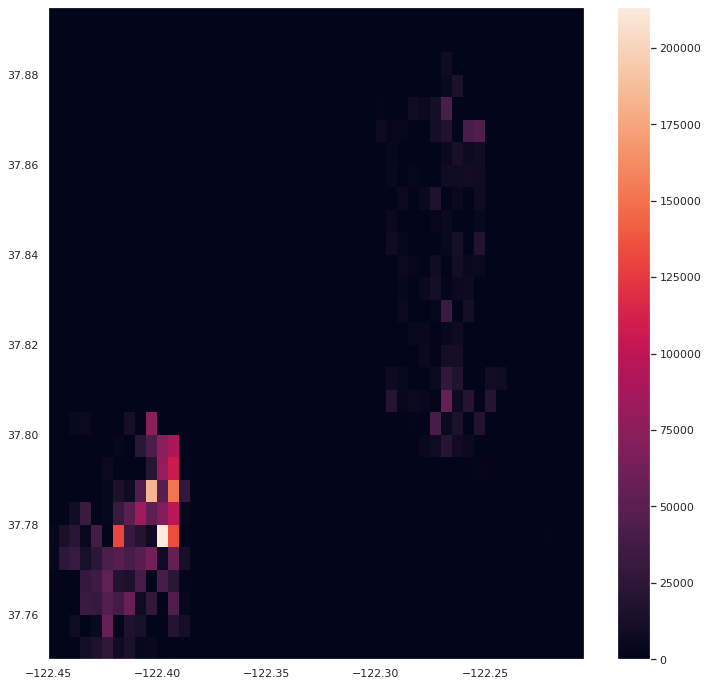

In [140]:
plt.figure(figsize = [12, 12])
bins_y = np.arange(37.75, 37.9, 0.005)
bins_x = np.arange(-122.45, -122.2, 0.005)
plt.hist2d(data = df, y = 'start_station_latitude', x = 'start_station_longitude',
           bins = [bins_x, bins_y])
plt.colorbar();

Our first attempt shows the vague contours of the Bay Area, with San Francisco in the left and Berekely and Oakland on the right. We'll zoom in on San Francisco.

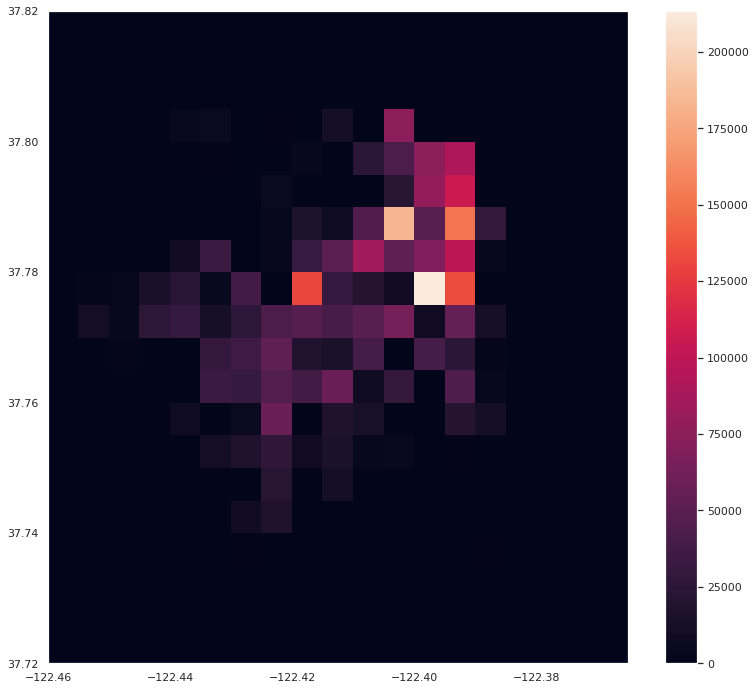

In [141]:
plt.figure(figsize = [13, 12])
bins_y = np.arange(37.72, 37.82, 0.005)
bins_x = np.arange(-122.46, -122.36, 0.005)
plt.hist2d(data = df, y = 'start_station_latitude', x = 'start_station_longitude',
           bins = [bins_x, bins_y])
plt.colorbar();

Again, we can make out San Francisco, but it's still a little vague. Graphing geographic data is a clever application of heatmaps, but it makes sense to use more specialized tool. We'll use the Google Maps API and see if that's better. First, we'll get the data into the necessary shape, then load it up.

In [142]:
df_2017['lat'] = df_2017.start_station_latitude.round(3)
df_2017['lon'] = df_2017.start_station_longitude.round(3)
geo_2017 = pd.DataFrame({'rides': df_2017[
    (df_2017.lon > -122.5) &  (df_2017.lon < -122.15) &
     (df_2017.lat > 37.7) &  (df_2017.lat < 38) ].groupby(['lat','lon']).size()}).reset_index()
geo_2017

,lat,lon,rides
0,37.742,-122.423,608
1,37.744,-122.427,1463
2,37.744,-122.421,1449
3,37.747,-122.411,1524
4,37.748,-122.425,431
...,...,...,...
225,37.872,-122.273,328
226,37.872,-122.266,24
227,37.874,-122.283,154
228,37.874,-122.269,704


In [143]:
df_2018['lat'] = df_2018.start_station_latitude.round(3)
df_2018['lon'] = df_2018.start_station_longitude.round(3)
geo_2018 = pd.DataFrame({'rides': df_2018[
    (df_2018.lon > -122.5) &  (df_2018.lon < -122.15) &
     (df_2018.lat > 37.7) &  (df_2018.lat < 38) ].groupby(['lat','lon']).size()}).reset_index()
geo_2018

,lat,lon,rides
0,37.729,-122.393,17
1,37.729,-122.392,35
2,37.730,-122.399,91
3,37.732,-122.390,163
4,37.739,-122.390,112
...,...,...,...
283,37.874,-122.269,1890
284,37.874,-122.268,894
285,37.875,-122.261,5927
286,37.877,-122.270,1465


In [144]:
df_2019['lat'] = df_2019.start_station_latitude.round(3)
df_2019['lon'] = df_2019.start_station_longitude.round(3)
geo_2019 = pd.DataFrame({'rides': df_2019[
    (df_2019.lon > -122.5) &  (df_2019.lon < -122.15) &
     (df_2019.lat > 37.7) &  (df_2019.lat < 38) ].groupby(['lat','lon']).size()}).reset_index()
geo_2019

,lat,lon,rides
0,37.712,-122.442,1
1,37.712,-122.404,1
2,37.712,-122.403,1
3,37.713,-122.459,1
4,37.713,-122.436,1
...,...,...,...
6188,37.888,-122.267,1
6189,37.888,-122.257,1
6190,37.891,-122.280,1
6191,37.892,-122.273,1


In [145]:
# https://jupyter-gmaps.readthedocs.io/en/stable/api.html

fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(geo_2017[['lat','lon']],
                                  weights=geo_2017.rides))
fig 

Figure(layout=FigureLayout(height='420px'))

In [146]:
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(geo_2018[['lat','lon']],
                                  weights=geo_2018.rides))
fig 

Figure(layout=FigureLayout(height='420px'))

In [147]:
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(geo_2019[['lat','lon']],
                                  weights=geo_2019.rides))
fig 

Figure(layout=FigureLayout(height='420px'))

The geo data agrees with what we've seen elsewhere: high frequency of usage in a very limited area, without much variation over time. As such, we'll run this visualization for the combined dataset.

In [148]:
df['lat'] = df.start_station_latitude.round(3)
df['lon'] = df.start_station_longitude.round(3)
geo_combined = pd.DataFrame({'rides': df[
    (df.lon > -122.5) &  (df.lon < -122.15) &
     (df.lat > 37.7) &  (df.lat < 38) ].groupby(['lat','lon']).size()}).reset_index()
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(geo_combined[['lat','lon']],
                                  weights=geo_combined.rides))
fig

Figure(layout=FigureLayout(height='420px'))

## Conclusions
[back to contents](#Contents)

My initial expectations were met, but in an unexpected fashion. While ridership has increased and the features have stabilized, usage is dominated by particular demographics. Riders are disproportionately young and male, and using the bike share during the work commute. This pattern took hold almost immediately after the inital rollout, and has only grown more dominant.

Most riders are subscribers, and these subscribers drive increased usage of the bike share. While this is promising for repeat business, it poses questions for growth. Presumably, we'd like to see more even ridership between males and females, and across age groups. Casual customers show different usage patterns, but the bike share doesn't seem to be attracting these kinds of users. This concentrated style of usage is mirrored by the location of rides, which is similarly concentrated in downtown San Francisco. If the bike share wants to expand its user base, it might focus on reaching out to underserved demographics: females, casual customers, and the East Bay.